<a href="https://colab.research.google.com/github/ziqlu0722/Info7374-GitHub-repo/blob/master/Assignment_2/SGD_ALEXNET_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os, zipfile, io, requests
URL = 'http://cs231n.stanford.edu/tiny-imagenet-200.zip'
def download_images(url):
    r = requests.get(url, stream=True)
    print ('Downloading ' + url )
    zip_ref = zipfile.ZipFile(io.BytesIO(r.content))
    zip_ref.extractall('./')
    zip_ref.close()
download_images(URL) #To download

In [0]:
import os
import pickle
import scipy.misc
import numpy as np
from scipy.misc import imread

In [0]:
def load_tiny_imagenet(path, wnids_path, resize='false', num_classes=200, dtype=np.float32):
  """
  Load TinyImageNet. Each of TinyImageNet-100-A, TinyImageNet-100-B, and
  TinyImageNet-200 have the same directory structure, so this can be used
  to load any of them.
  Inputs:
  - path: String giving path to the directory to load.
  - dtype: numpy datatype used to load the data.
  Returns: A tuple of
  - class_names: A list where class_names[i] is a list of strings giving the
    WordNet names for class i in the loaded dataset.
  - X_train: (N_tr, 3, 64, 64) array of training images
  - y_train: (N_tr,) array of training labels
  - X_val: (N_val, 3, 64, 64) array of validation images
  - y_val: (N_val,) array of validation labels
  - X_test: (N_test, 3, 64, 64) array of testing images.
  - y_test: (N_test,) array of test labels; if test labels are not available
    (such as in student code) then y_test will be None.
  """
  # First load wnids
  wnids_file = os.path.join(wnids_path, 'wnids.txt')
  with open(os.path.join(path, wnids_file), 'r') as f:
    wnids = [x.strip() for x in f]

  # Map wnids to integer labels
  wnid_to_label = {wnid: i for i, wnid in enumerate(wnids)}

  # Use words.txt to get names for each class
  words_file = os.path.join(wnids_path, 'words.txt')
  with open(os.path.join(path, words_file), 'r') as f:
    wnid_to_words = dict(line.split('\t') for line in f)
    for wnid, words in wnid_to_words.items():
      wnid_to_words[wnid] = [w.strip() for w in words.split(',')]
  class_names = [wnid_to_words[wnid] for wnid in wnids]

  # Next load training data.
  X_train = []
  y_train = []
  for i, wnid in enumerate(wnids):
    if (i + 1) % 20 == 0:
      print('loading training data for synset %d / %d' % (i + 1, len(wnids)))
    # To figure out the filenames we need to open the boxes file
    boxes_file = os.path.join(path, 'train', wnid, '%s_boxes.txt' % wnid)
    with open(boxes_file, 'r') as f:
      filenames = [x.split('\t')[0] for x in f]
    num_images = len(filenames)
    
    if resize.lower() == 'true':
      X_train_block = np.zeros((num_images, 3, 32, 32), dtype=dtype)
    else:
      X_train_block = np.zeros((num_images, 3, 64, 64), dtype=dtype)
    
    y_train_block = wnid_to_label[wnid] * np.ones(num_images, dtype=np.int64)
    for j, img_file in enumerate(filenames):
      img_file = os.path.join(path, 'train', wnid, 'images', img_file)
      img = imread(img_file)
      
      if resize.lower() == 'true':
        img = scipy.misc.imresize(img, (32, 32, 3))
      if img.ndim == 2:
        ## grayscale file
        if resize.lower() == 'true':
          img.shape = (32, 32, 1)
        else:
          img.shape = (64, 64, 1)
      X_train_block[j] = img.transpose(2, 0, 1)
    X_train.append(X_train_block)
    y_train.append(y_train_block)
      
  # We need to concatenate all training data
  X_train = np.concatenate(X_train, axis=0)
  y_train = np.concatenate(y_train, axis=0)
  
  # Next load validation data
  with open(os.path.join(path, 'val', 'val_annotations.txt'), 'r') as f:
    img_files = []
    val_wnids = []
    for line in f:
      # Select only validation images in chosen wnids set
      if line.split()[1] in wnids:
        img_file, wnid = line.split('\t')[:2]
        img_files.append(img_file)
        val_wnids.append(wnid)
    num_val = len(img_files)
    y_val = np.array([wnid_to_label[wnid] for wnid in val_wnids])
    
    if resize.lower() == 'true':
      X_val = np.zeros((num_val, 3, 32, 32), dtype=dtype)
    else:
      X_val = np.zeros((num_val, 3, 64, 64), dtype=dtype)
 
    for i, img_file in enumerate(img_files):
      img_file = os.path.join(path, 'val', 'images', img_file)
      img = imread(img_file)
      if resize.lower() == 'true':
        img = scipy.misc.imresize(img, (32, 32, 3))
      if img.ndim == 2:
        if resize.lower() == 'true':
          img.shape = (32, 32, 1)
        else:
          img.shape = (64, 64, 1)

      X_val[i] = img.transpose(2, 0, 1)

  """
  # Next load test images
  # Students won't have test labels, so we need to iterate over files in the
  # images directory.
  img_files = os.listdir(os.path.join(path, 'test', 'images'))
  X_test = np.zeros((len(img_files), 3, 64, 64), dtype=dtype)
  for i, img_file in enumerate(img_files):
    img_file = os.path.join(path, 'test', 'images', img_file)
    img = imread(img_file)
    if img.ndim == 2:
      img.shape = (64, 64, 1)
    X_test[i] = img.transpose(2, 0, 1)
  y_test = None
  y_test_file = os.path.join(path, 'test', 'test_annotations.txt')
  if os.path.isfile(y_test_file):
    with open(y_test_file, 'r') as f:
      img_file_to_wnid = {}
      for line in f:
        line = line.split('\t')
        img_file_to_wnid[line[0]] = line[1]
    y_test = [wnid_to_label[img_file_to_wnid[img_file]] for img_file in img_files]
    y_test = np.array(y_test)
  """
  
  # Omit x_test and y_test because they're unlabeled
  #return class_names, X_train, y_train, X_val, y_val, X_test, y_test
  return class_names, X_train, y_train, X_val, y_val

In [0]:
class_names,X_train, y_train,X_val,y_val = load_tiny_imagenet('tiny-imagenet-200',"",resize='true')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:59: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


loading training data for synset 20 / 200
loading training data for synset 40 / 200
loading training data for synset 60 / 200
loading training data for synset 80 / 200
loading training data for synset 100 / 200
loading training data for synset 120 / 200
loading training data for synset 140 / 200
loading training data for synset 160 / 200
loading training data for synset 180 / 200
loading training data for synset 200 / 200


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:94: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


In [0]:
import keras

x_train = X_train.astype('float32')



x_test = X_val.astype('float32')

Using TensorFlow backend.


In [0]:
x_train /= 255

x_test /= 255

In [0]:
import keras

y_train = keras.utils.to_categorical(y_train, len(class_names))



y_val = keras.utils.to_categorical(y_val, len(class_names))

Using TensorFlow backend.


In [0]:
import argparse

# Import necessary components to build LeNet
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2

img_shape=(32,32, 3)
n_classes=10
l2_reg=0.
weights=None

	# Initialize model
alexnet = Sequential()

	# Layer 1
alexnet.add(Conv2D(96, (11, 11), input_shape=img_shape,
padding='same',kernel_regularizer=l2(l2_reg)))
alexnet.add(BatchNormalization())
alexnet.add(Activation('relu'))
alexnet.add(MaxPooling2D(pool_size=(2, 2)))

	# Layer 2
alexnet.add(Conv2D(256, (5, 5), padding='same'))
alexnet.add(BatchNormalization())
alexnet.add(Activation('relu'))
alexnet.add(MaxPooling2D(pool_size=(2, 2)))

	# Layer 3
alexnet.add(ZeroPadding2D((1, 1)))
alexnet.add(Conv2D(512, (3, 3), padding='same'))
alexnet.add(BatchNormalization())
alexnet.add(Activation('relu'))
alexnet.add(MaxPooling2D(pool_size=(2, 2)))

	# Layer 4
alexnet.add(ZeroPadding2D((1, 1)))
alexnet.add(Conv2D(1024, (3, 3), padding='same'))
alexnet.add(BatchNormalization())
alexnet.add(Activation('relu'))

	# Layer 5
alexnet.add(ZeroPadding2D((1, 1)))
alexnet.add(Conv2D(1024, (3, 3), padding='same'))
alexnet.add(BatchNormalization())
alexnet.add(Activation('relu'))
alexnet.add(MaxPooling2D(pool_size=(2, 2)))

	# Layer 6
alexnet.add(Flatten())
alexnet.add(Dense(3072))
alexnet.add(BatchNormalization())
alexnet.add(Activation('relu'))
alexnet.add(Dropout(0.5))

	# Layer 7
alexnet.add(Dense(4096))
alexnet.add(BatchNormalization())
alexnet.add(Activation('relu'))
alexnet.add(Dropout(0.5))

	# Layer 8
alexnet.add(Dense(200))
alexnet.add(BatchNormalization())
alexnet.add(Activation('softmax'))

alexnet.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 96)        34944     
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 96)        384       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 96)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 96)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 256)       614656    
_________________________________________________________________
batch_normalization_2

In [0]:
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os



In [0]:
alexnet.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.SGD(lr=0.01, momentum=0.5, decay=0.001, nesterov=True),
              metrics=['accuracy'])


history = alexnet.fit(np.array(X_train.transpose(0,3,2,1)),np.array(y_train),
                    epochs=10,
                    batch_size=256,
                    verbose=1,
                    validation_data=(np.array(X_val.transpose(0,3,2,1)),np.array(y_val)))

Instructions for updating:
Use tf.cast instead.
Train on 100000 samples, validate on 10000 samples
Epoch 1/10
100000/100000 [==============================] - 262s 3ms/step - loss: 5.1023 - acc: 0.0283 - val_loss: 4.7902 - val_acc: 0.0554
Epoch 2/10
100000/100000 [==============================] - 246s 2ms/step - loss: 4.7193 - acc: 0.0594 - val_loss: 4.5480 - val_acc: 0.0893
Epoch 3/10
100000/100000 [==============================] - 246s 2ms/step - loss: 4.5536 - acc: 0.0799 - val_loss: 4.4662 - val_acc: 0.0997
Epoch 4/10
100000/100000 [==============================] - 246s 2ms/step - loss: 4.4444 - acc: 0.0953 - val_loss: 4.3668 - val_acc: 0.1164
Epoch 5/10
100000/100000 [==============================] - 246s 2ms/step - loss: 4.3543 - acc: 0.1075 - val_loss: 4.3739 - val_acc: 0.1186
Epoch 6/10
100000/100000 [==============================] - 246s 2ms/step - loss: 4.2790 - acc: 0.1201 - val_loss: 4.2676 - val_acc: 0.1314
Epoch 7/10
100000/100000 [==============================] - 2

In [0]:
alexnet.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.SGD(lr=0.01, momentum=0.5, decay=0.001, nesterov=True),
              metrics=['accuracy'])


history = alexnet.fit(np.array(X_train.transpose(0,3,2,1)),np.array(y_train),
                    epochs=20,
                    batch_size=256,
                    verbose=1,
                    validation_data=(np.array(X_val.transpose(0,3,2,1)),np.array(y_val)))

Train on 100000 samples, validate on 10000 samples
Epoch 1/20
100000/100000 [==============================] - 249s 2ms/step - loss: 4.0984 - acc: 0.1495 - val_loss: 4.1041 - val_acc: 0.1548
Epoch 2/20
100000/100000 [==============================] - 246s 2ms/step - loss: 3.9679 - acc: 0.1692 - val_loss: 4.0688 - val_acc: 0.1577
Epoch 3/20
100000/100000 [==============================] - 246s 2ms/step - loss: 3.8660 - acc: 0.1863 - val_loss: 4.1697 - val_acc: 0.1392
Epoch 4/20
100000/100000 [==============================] - 246s 2ms/step - loss: 3.7879 - acc: 0.2003 - val_loss: 3.8203 - val_acc: 0.1999
Epoch 5/20
100000/100000 [==============================] - 246s 2ms/step - loss: 3.7255 - acc: 0.2117 - val_loss: 3.9835 - val_acc: 0.1621
Epoch 6/20
100000/100000 [==============================] - 246s 2ms/step - loss: 3.6629 - acc: 0.2224 - val_loss: 3.8507 - val_acc: 0.1971
Epoch 7/20
100000/100000 [==============================] - 246s 2ms/step - loss: 3.6113 - acc: 0.2310 - val_

Test loss: 3.512125574874878
Test accuracy: 0.2507
dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


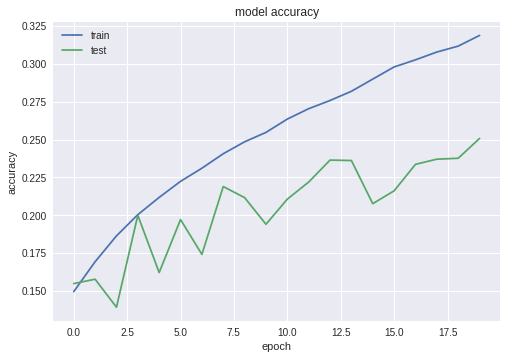

In [0]:
score = alexnet.evaluate(np.array(X_val.transpose(0,3,2,1)),np.array(y_val), verbose=0)
                       
print('Test loss:', score[0])
print('Test accuracy:', score[1])


import matplotlib.pyplot as plt
import numpy

print(history.history.keys())
#summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc']) 
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()